# Evaluation

## Requirements

In [84]:
import os
import json
import pandas as pd
from pymongo import MongoClient
from collections import Counter
import matplotlib.pyplot as plt

## Evaluation helper methods

In [74]:
# Change global plot settings
plt.rcParams.update({'font.size': 24})

In [48]:
def labelBars(plot):
    for p in plot.patches:
        plot.annotate(
            np.round(p.get_height(), decimals=2),
            (
                p.get_x() + p.get_width() / 2.,
                p.get_height()
            ),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points'
        )
    return plot

In [119]:
client = MongoClient()
db = client.bob
tables = db.tables
cursor = tables.find({"annotatedAt" : {"$exists" : True}, "skipped": {"$ne": True}})
tables = pd.DataFrame(list(cursor))
client.close()
tables.head()

,_id,annotatedAt,annotations,features,html,logBin,pageID,pageTitle,predictions,tableIndex,tableTitle,taggedHtml
0,5d020c07e7ee03eab39a8342,1.560438e+12,"[Header, Data]","{'0': {'isPartiallyBoldBl': 0, 'isTHOrInTHead'...","<table bgcolor=""#f8f9fa"" border=""1"" class=""wik...","{'0': {'isPartiallyBoldBl': {'a': 0, 'b': 0}, ...",10002196,Got to Have Your Love,NaN,4,Release history[edit],"<table bgcolor=""#f8f9fa"" border=""1"" class=""wik..."
1,5d020c07e7ee03eab39a8329,1.560440e+12,"[Header, Data, Data, Data, Data, Data, Data]","{'0': {'isPartiallyBoldBl': 0, 'isTHOrInTHead'...","<table bgcolor=""#f8f9fa"" class=""wikitable"" sty...","{'0': {'isPartiallyBoldBl': {'a': 0, 'b': 0}, ...",1000141,Thales (crater),NaN,0,Satellite craters[edit],"<table bgcolor=""#f8f9fa"" class=""wikitable"" sty..."
2,5d020c07e7ee03eab39a831e,1.560438e+12,"[Header, Header, Data, Data, Data, Other, Othe...","{'0': {'isPartiallyBoldBl': 0, 'isTHOrInTHead'...","<table bgcolor=""#f8f9fa"" border=""1"" cellpaddin...","{'0': {'isPartiallyBoldBl': {'a': 0, 'b': 0}, ...",1000102,1977 Manitoba general election,NaN,2,Riding results[edit],"<table bgcolor=""#f8f9fa"" border=""1"" cellpaddin..."
3,5d020c07e7ee03eab39a8379,1.560438e+12,"[Header, Data, Data, Data, Data, Data, Data, D...","{'0': {'isPartiallyBoldBl': 0, 'isTHOrInTHead'...","<table bgcolor=""#f8f9fa"" class=""wikitable sort...","{'0': {'isPartiallyBoldBl': {'a': 0, 'b': 0}, ...",100039,Clarence Nash,NaN,2,Film[edit],"<table bgcolor=""#f8f9fa"" class=""wikitable sort..."
4,5d020c07e7ee03eab39a8382,1.560439e+12,"[Data, Data, Data, Data, Data, Other]","{'0': {'isPartiallyBoldBl': 0, 'isTHOrInTHead'...","<table bgcolor=""#f8f9fa"" class=""wikitable"" sty...","{'0': {'isPartiallyBoldBl': {'a': 0, 'b': 0}, ...",100040,Richmond Football Club,"[Header, Data, Data, Data, Data, Other]",6,Club records[edit],"<table bgcolor=""#f8f9fa"" class=""wikitable"" sty..."


In [120]:
testTables = pd.DataFrame(json.load(open(os.path.join('..', 'data', 'test.json'), 'r')).values(), columns=['_id'])
testTables = testTables['_id'].apply(lambda tableID: tables.loc[tables['_id'].astype(str) == tableID].iloc[0])

In [81]:
trainTables = pd.DataFrame(json.load(open(os.path.join('..', 'data', 'train.json'), 'r')).values(), columns=['_id'])
trainTables = trainTables['_id'].apply(lambda tableID: tables.loc[tables['_id'].astype(str) == tableID].iloc[0])

### Table count per dataset

In [82]:
print('Total tables count: ', len(tables))
print('Training tables count: ', len(trainTables))
print('Test tables count: ', len(testTables))

Total tables count:  929
Training tables count:  650
Test tables count:  279


### Avg. Table size (row count) per dataset

In [83]:
def getRowCount(tables):
    return tables.apply(lambda table: len(table['annotations']), axis='columns')

print('Avg. table size for training set: ', round(getRowCount(trainTables).mean()))
print('Avg. table size for training set: ', round(getRowCount(testTables).mean()))
print('Avg. table size for training set: ', round(getRowCount(tables).mean()))

Avg. table size for training set:  15
Avg. table size for training set:  15
Avg. table size for training set:  15


## Dataset cell type ratios

In [33]:
totalCounter = Counter([item for sublist in list(tables['annotations'].values) for item in sublist])
trainCounter = Counter([item for sublist in list(trainTables['annotations'].values) for item in sublist])
testCounter = Counter([item for sublist in list(testTables['annotations'].values) for item in sublist])

[Text(0, 0.5, 'Annotation'),
 Text(0.5, 0, 'Percentage'),
 Text(0.5, 1.0, 'Distribution of cell types accross datasets')]

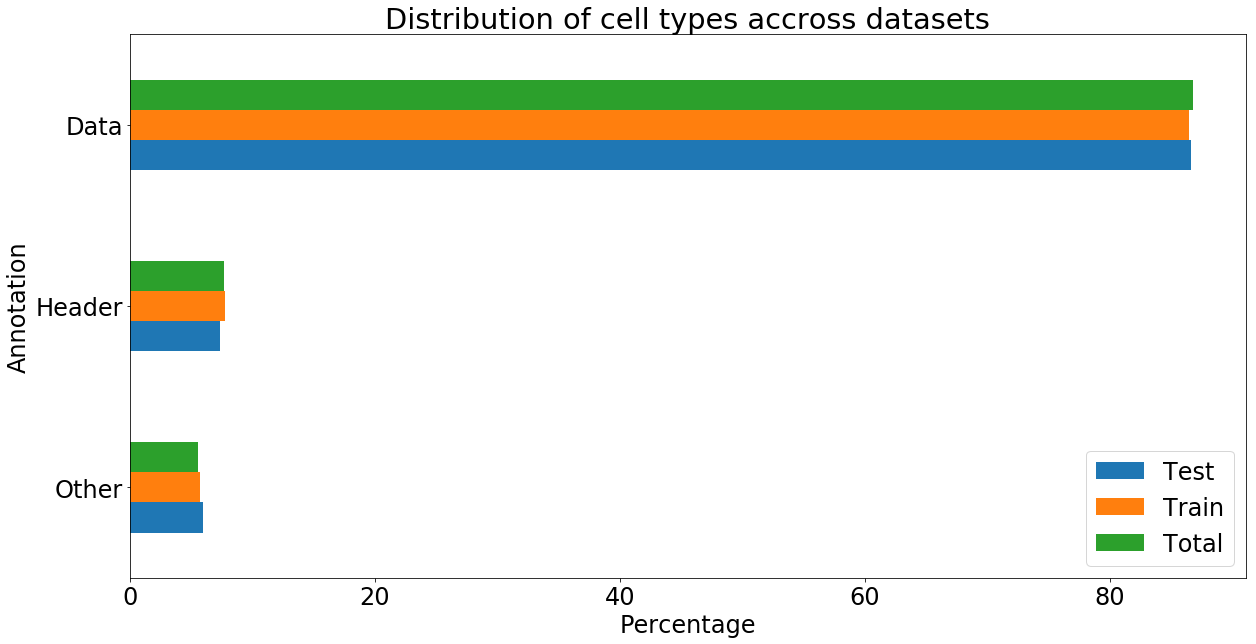

In [75]:
def getRatio(counter):
    total = sum(list(counter.values()))
    return [counter[annotation] * 100.0 / total for annotation in ['Other', 'Header', 'Data']]
    
ratios = [getRatio(testCounter), getRatio(trainCounter), getRatio(totalCounter)]
ratioLabels = ['Test', 'Train', 'Total']
ratioDf = pd.DataFrame(ratios, index=ratioLabels, columns=['Other', 'Header', 'Data']).T
ratioPlot = ratioDf.plot(kind='barh', figsize=(20, 10))
ratioPlot.set(
    xlabel="Percentage",
    ylabel="Annotation", 
    title="Distribution of cell types accross datasets"
)

## Correctly predicted tables

In [115]:
client = MongoClient()
db = client.bob
tables = db.tables
cursor = tables.find({"predictions" : {"$exists" : True}})
predictedTables = pd.DataFrame(list(cursor))
client.close()
predictedTables.head()

,_id,annotatedAt,annotations,features,html,logBin,pageID,pageTitle,predictions,tableIndex,tableTitle,taggedHtml
0,5d020c07e7ee03eab39a8382,1.560439e+12,"[Data, Data, Data, Data, Data, Other]","{'0': {'isPartiallyBoldBl': 0, 'isTHOrInTHead'...","<table bgcolor=""#f8f9fa"" class=""wikitable"" sty...","{'0': {'isPartiallyBoldBl': {'a': 0, 'b': 0}, ...",100040,Richmond Football Club,"[Header, Data, Data, Data, Data, Other]",6,Club records[edit],"<table bgcolor=""#f8f9fa"" class=""wikitable"" sty..."
1,5d020c07e7ee03eab39a83ec,1.560439e+12,"[Header, Data, Data, Data, Header, Data, Heade...","{'0': {'isPartiallyBoldBl': 0, 'isTHOrInTHead'...","<table bgcolor=""#f8f9fa"" class=""wikitable sort...","{'0': {'isPartiallyBoldBl': {'a': 0, 'b': 0}, ...",1000616,No Prayer for the Dying,"[Header, Data, Data, Other, Header, Data, Head...",2,Singles[edit],"<table bgcolor=""#f8f9fa"" class=""wikitable sort..."
2,5d020c07e7ee03eab39a83ca,1.560438e+12,"[Header, Other, Header, Data, Data, Data, Data...","{'0': {'isPartiallyBoldBl': 0, 'isTHOrInTHead'...","<table align=""center"" bgcolor=""#f8f9fa"" class=...","{'0': {'isPartiallyBoldBl': {'a': 0, 'b': 0}, ...",10005298,Yon García,"[Header, Header, Header, Data, Data, Data, Dat...",1,Results[edit],"<table align=""center"" bgcolor=""#f8f9fa"" class=..."
3,5d020c07e7ee03eab39a840e,1.560439e+12,"[Header, Data, Data]","{'0': {'isPartiallyBoldBl': 0, 'isTHOrInTHead'...","<table bgcolor=""#f8f9fa"" class=""wikitable"" sty...","{'0': {'isPartiallyBoldBl': {'a': 0, 'b': 0}, ...",10007332,Nightwish discography,"[Header, Data, Data]",8,Demo albums[edit],"<table bgcolor=""#f8f9fa"" class=""wikitable"" sty..."
4,5d020c07e7ee03eab39a8434,1.560440e+12,"[Header, Header, Data]","{'0': {'isPartiallyBoldBl': 0, 'isTHOrInTHead'...","<table bgcolor=""#f8f9fa"" class=""wikitable"" sty...","{'0': {'isPartiallyBoldBl': {'a': 0, 'b': 0}, ...",10008653,Igaya Station,"[Header, Header, Data]",0,Adjacent stations[edit],"<table bgcolor=""#f8f9fa"" class=""wikitable"" sty..."


In [86]:
def getWronglyPredicted(table):
    incorrect = []
    for rowIndex, label in enumerate(table['annotations']):
        if(label != table['predictions'][rowIndex]):
            incorrect.append({
                'annotated': label,
                'predicted': table['predictions'][rowIndex]
            })
    return incorrect

def getCorrectlyPredictedCount(table):
    return len(table['annotations']) - table['predictedIncorrectlyCount']
    
def isWholeTableCorrectlyPredicted(table):
    return table['predictedCorrectlyCount'] == len(table['annotations'])

def getIncorrectlyPredictedCount(table):
    return len(table['wronglyPredicted'])

In [87]:
predictedTables['wronglyPredicted'] = predictedTables.apply(getWronglyPredicted, axis='columns')
predictedTables['predictedIncorrectlyCount'] = predictedTables.apply(getIncorrectlyPredictedCount, axis='columns')
predictedTables['predictedCorrectlyCount'] = predictedTables.apply(getCorrectlyPredictedCount, axis='columns')
predictedTables['predictedCorrectly'] = predictedTables.apply(isWholeTableCorrectlyPredicted, axis='columns')

In [88]:
correctlyPredictedTables = predictedTables.loc[predictedTables['predictedCorrectly']].shape[0]
print('Correctly predicted table count: ' + str(correctlyPredictedTables))

Correctly predicted table count: 227


In [89]:
incorrectPredictedTables = predictedTables.loc[~predictedTables['predictedCorrectly']]
incorrectPredictedTables.reset_index(inplace=True)
incorrectPredictedTableCount = incorrectPredictedTables.shape[0]
print('Incorrect predicted table count: ' + str(incorrectPredictedTableCount))

Incorrect predicted table count: 52


## Correctly predicted rows

[Text(0, 0.5, 'Amount of tables'),
 Text(0.5, 0, 'Amount of incorrectly labeled rows per table'),
 Text(0.5, 1.0, 'Incorrectly labled rows per table')]

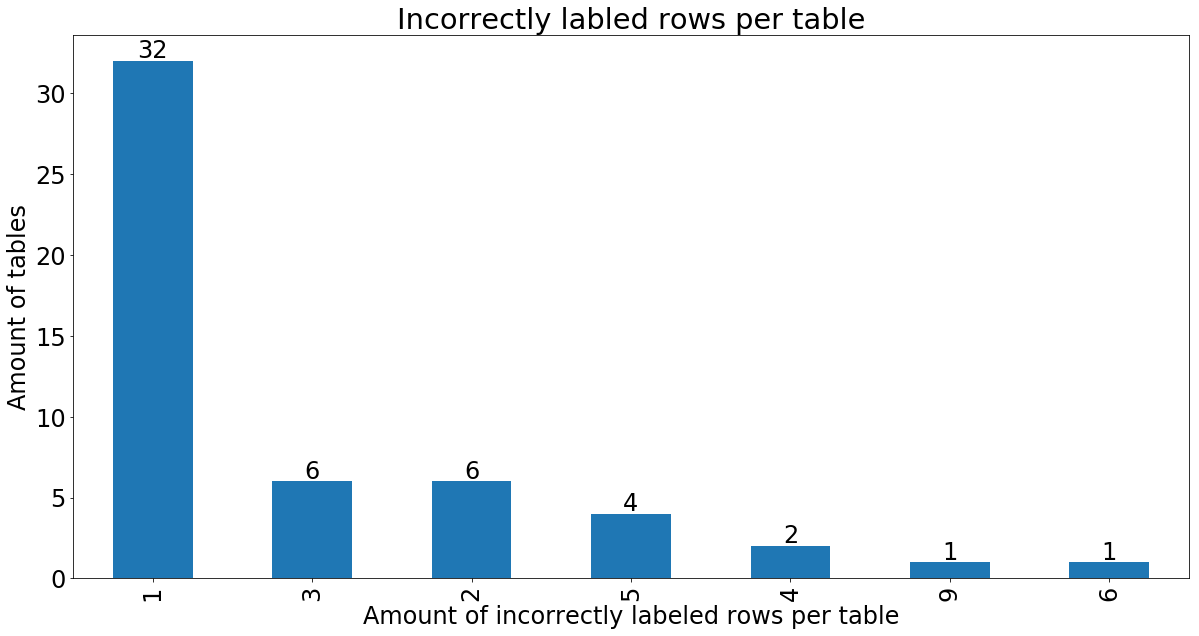

In [90]:
numberOfIncorrectRowsPerTablePlot = incorrectPredictedTables['predictedIncorrectlyCount'].value_counts().plot(
    kind='bar', 
    figsize=(20, 10)
)
labelBars(numberOfIncorrectRowsPerTablePlot)
numberOfIncorrectRowsPerTablePlot.set(
   xlabel='Amount of incorrectly labeled rows per table',
    ylabel='Amount of tables',
    title='Incorrectly labled rows per table'
)

[Text(0, 0.5, 'Amount of tables'),
 Text(0.5, 0, 'Table size (total table row count)'),
 Text(0.5, 1.0, 'Dependency between table size (total row count) and prediction correctness')]

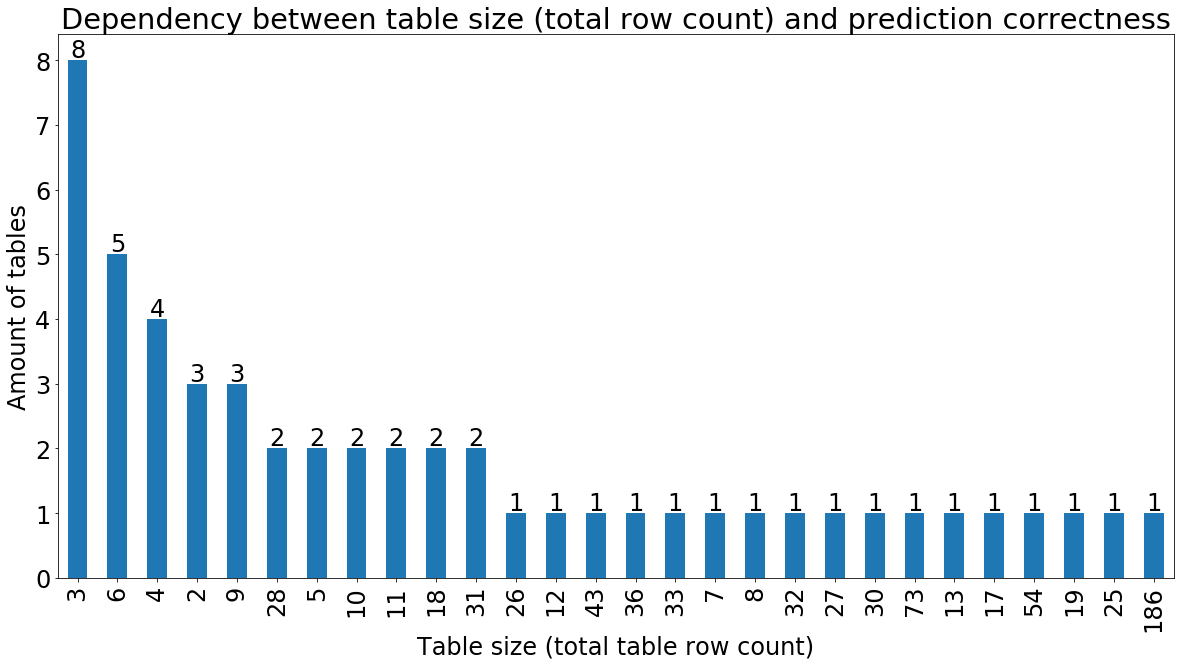

In [91]:
def getRowCount(table):
    return len(table['annotations'])

rowCountPerTablePlot = incorrectPredictedTables.apply(getRowCount, axis='columns').value_counts().plot(
    kind='bar', 
    figsize=(20, 10)
)
labelBars(rowCountPerTablePlot)
rowCountPerTablePlot.set(
   xlabel='Table size (total table row count)',
    ylabel='Amount of tables',
    title='Dependency between table size (total row count) and prediction correctness'
)

In [92]:
wronglyPredicted = list(incorrectPredictedTables['wronglyPredicted'])
wronglyPredicted = [item for sublist in wronglyPredicted for item in sublist]
wronglyPredicted = pd.DataFrame(wronglyPredicted)
print('Count of which row type got predicted incorrectly:')
wronglyPredicted.groupby('annotated').count()

Count of which row type got predicted incorrectly:


,predicted
annotated,
Data,16
Header,20
Other,69


In [140]:
def getLabeledAsMatrix(tables):
    labeledAs = {}
    for iRow, table in tables.iterrows():
        for iAnnotation, annotation in enumerate(table['annotations']):
            currentLabelDict = labeledAs.get(annotation, {})
            predictedAs = table['predictions'][iAnnotation]
            currentLabelDict[predictedAs] = currentLabelDict.get(predictedAs, 0) + 1
            labeledAs[annotation] = currentLabelDict
    return labeledAs

In [154]:
labeledAsMatrix = getLabeledAsMatrix(testTables)
labeledAsMatrixPD = pd.DataFrame(labeledAsMatrix.values(), index=labeledAsMatrix.keys())
labeledAsMatrixPD.fillna(0, inplace=True)
labeledAsMatrixPD
# ratioDf = pd.DataFrame(ratios, index=ratioLabels, columns=['Other', 'Header', 'Data']).T


,Data,Header,Other
Header,20,298,0.0
Data,3702,3,13.0
Other,55,14,187.0


## More detailed analysis

In [ ]:
print('Table ids of incorrectly predicted tables')
pd.set_option('display.max_colwidth', -1)
incorrectPredictedTables[['_id', 'predictions']]

## Possible reasons for incorrect labeling (1):
- background color not taken into account enough -> to less examples where background color indicates Header or to many example where a colored cell is not a Header cell
- It's a legend and marked as data while we would label it as 'Other' -> taking into account the occurrence of characters like '=' ':' could help?
- merged cell doesn't seem to be a good indicator that cell should be 'Other' instead of 'Data'
- group header mistaken as real header
- maybe the tables (with many rows) in the test set had no header and therefor the size was more important? (need to check if row/col count is taken as feature)
- 'bold' style doesn't indicate if it's a header for sure -> tr/thead feature is more important -> if tr/thead is missing, but cell is bold the row still gets marked as 'Data' instead of 'Header' -> introduce feature accross whole row for bold too